## 필요한 라이브러리 import

In [24]:
import torch
import torch.nn as nn

import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import os
from torchvision import datasets, transforms
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## data load 및 전처리

In [25]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

num_classes = 100  # For CGAN

Files already downloaded and verified


## CIFAR 100

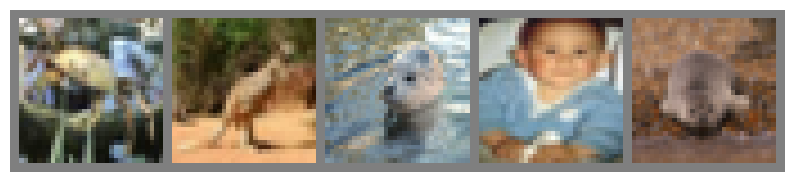

In [26]:
def imshow_grid(images):
    images = images / 2 + 0.5
    npimg = images.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

indices = torch.randint(0, len(dataset), (5,))
images = [dataset[i][0] for i in indices]

grid_image = torchvision.utils.make_grid(images, nrow=5)
imshow_grid(grid_image)

## GAN model define

conv연산을 이용하여 쌓기위해 DCGAN을 기반으로 진행함.

DCGAN이랑 Deep Convolutional GAN의 줄임말로, 기존 GAN에 CNN 구조를 적용한 버전이라고 생각하면 된다.

- Generator

    - ConvTranspose2d를 이용하여 이미지 업샘플링을 진행

    - (DCGAN 논문 구조 그대로)

- Discriminator

  - 처음 이미지 채널을 64로 줄이고 다운샘플링 진행
  - leakyReLU를 통해 죽은 뉴런 방지

  


In [27]:
 class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3, feature_g=64):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(z_dim, feature_g * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_g * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_g * 8, feature_g * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_g * 4, feature_g * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_g * 2, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)

In [28]:
class Discriminator(nn.Module):
    def __init__(self, img_channels=3, feature_d=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(img_channels, feature_d, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d, feature_d * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_d * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d * 2, feature_d * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_d * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x).view(-1)

## GAN train 함수

- BCE loss
Binary Cross Entropy(BCE) Loss는 Binary Classification 문제에서 사용되는 손실 함수로, 주어진 예측값과 실제값 간의 차이를 계산하여 모델이 얼마나 잘 맞추었는지 평가하는 역할을 함.

직관적으로 예측값과 실제값의 확률 분포 차이를 줄이는 방향으로 학습
  
  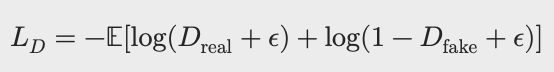

  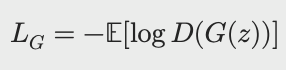

In [29]:
def train_gan(generator, discriminator, num_epochs=50, z_dim=100, g_steps=2, d_steps=1):
    optimizer_G = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

    generator.to(device)
    discriminator.to(device)

    fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

    for epoch in range(num_epochs):
        for i, (real, _) in enumerate(dataloader):
            real = real.to(device)
            b_size = real.size(0)

            # === Train Discriminator ===
            for _ in range(d_steps):
                noise = torch.randn(b_size, z_dim, 1, 1, device=device)
                fake = generator(noise) # 랜덤 노이즈로 fake 이미지 생성
                D_real = discriminator(real).mean() # 진짜 이미지에 대한 D의 출력값으로 높을수록 좋아
                D_fake = discriminator(fake.detach()).mean() # 생성된 가짜 이미지에 대한 D의 출력으로 낮을수록 좋아
                loss_D = -(torch.log(D_real + 1e-8) + torch.log(1 - D_fake + 1e-8)).mean()

                optimizer_D.zero_grad()
                loss_D.backward()
                optimizer_D.step()

            # === Train Generator ===  D가 G의 이미지를 진짜라고 판단하도록 만드는 것이 목표
            for _ in range(g_steps):
                noise = torch.randn(b_size, z_dim, 1, 1, device=device)
                fake = generator(noise)
                output = discriminator(fake).mean()
                loss_G = -torch.log(output + 1e-8).mean()

                optimizer_G.zero_grad()
                loss_G.backward()
                optimizer_G.step()

        print(f"Epoch {epoch+1}/{num_epochs} | Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")

        if (epoch + 1) % 10 == 0:
            with torch.no_grad():
                fake_images = generator(fixed_noise).detach().cpu()
                grid = vutils.make_grid(fake_images, padding=2, normalize=True)
                plt.figure(figsize=(8, 8))
                plt.axis("off")
                plt.title(f"Generated Images at Epoch {epoch+1}")
                plt.imshow(np.transpose(grid, (1, 2, 0)))
                plt.show()

In [30]:
g_gan = Generator().to(device)
d_gan = Discriminator().to(device)

train_gan(g_gan, d_gan, num_epochs=50)

Output hidden; open in https://colab.research.google.com to view.

## CGAN

Conditional GAN은 조건부 GAN으로 생성된 이미지를 특정 조건에 맞게 생성하는 모델이다.

여기서 조건은 label, 텍스트설명, 이미지 등 다양한 형태일 수 있으나 주로 label을 의미하게 된다.

조건 정보가 있을 때, 생성자는 조건에 맞는 이미지를 생성하며, 판별자는 조건에 맞는 진짜 데이터를 구별하려고 학습한다.

In [46]:
class CGAN_Generator(nn.Module):
    def __init__(self, z_dim=100, num_classes=100, img_channels=3, feature_g=64):
        super(CGAN_Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, 50) # 라벨 임베딩을 추가
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(z_dim + 50, feature_g * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_g * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_g * 8, feature_g * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_g * 4, feature_g * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_g * 2, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_embed = self.label_emb(labels).unsqueeze(2).unsqueeze(3) # unsqueeze는 텐서에 차원을 추가하는 함수, z와 label_embed를 결합할 수 있도록
        x = torch.cat([z, label_embed], dim=1) # z와 label_embed를 channel을 기준으로 이어붙임
        return self.gen(x)

In [47]:
class CGAN_Discriminator(nn.Module):
    def __init__(self, num_classes=100, img_channels=3, feature_d=64):
        super(CGAN_Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, 50)
        self.disc = nn.Sequential(
            nn.Conv2d(img_channels + 50, feature_d, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(feature_d, feature_d * 2, 4, 2, 1),
            nn.BatchNorm2d(feature_d * 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(feature_d * 2, 1, 4, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        label_embed = self.label_emb(labels).unsqueeze(2).unsqueeze(3).expand(-1, -1, x.size(2), x.size(3))
        x = torch.cat([x, label_embed], dim=1)
        return self.disc(x).view(-1)

In [48]:
def train_cgan(generator, discriminator, num_epochs=50, z_dim=100):
    criterion = nn.BCELoss()
    optimizer_G = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

    generator.to(device)
    discriminator.to(device)

    fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)
    fixed_labels = torch.randint(0, num_classes, (64,), device=device)

    for epoch in range(num_epochs):
        for real, labels in dataloader:
            real, labels = real.to(device), labels.to(device)
            b_size = real.size(0)

            # Train Discriminator
            noise = torch.randn(b_size, z_dim, 1, 1, device=device)
            fake = generator(noise, labels)
            D_real = discriminator(real, labels)
            D_fake = discriminator(fake.detach(), labels)

            # Apply label smoothing
            real_labels = torch.ones_like(D_real) * 0.9  # Label smoothing: 진짜 이미지에 0.9를 사용
            fake_labels = torch.zeros_like(D_fake)       # 가짜 이미지에 0을 사용

            # Discriminator loss
            loss_D_real = criterion(D_real, real_labels)  # 진짜 이미지에 대한 손실
            loss_D_fake = criterion(D_fake, fake_labels)  # 가짜 이미지에 대한 손실
            loss_D = (loss_D_real + loss_D_fake) / 2

            optimizer_D.zero_grad()
            loss_D.backward()
            optimizer_D.step()

            # Train Generator
            output = discriminator(fake, labels)
            loss_G = criterion(output, torch.ones_like(output))  # Generator는 가짜 이미지를 진짜처럼 만들려 하므로 1을 목표로
            optimizer_G.zero_grad()
            loss_G.backward()
            optimizer_G.step()

        print(f"Epoch {epoch+1}/{num_epochs} | Loss D: {loss_D.item():.4f} | Loss G: {loss_G.item():.4f}")

        if (epoch + 1) % 10 == 0:
            with torch.no_grad():
                gen_imgs = generator(fixed_noise, fixed_labels).detach().cpu()
                grid = vutils.make_grid(gen_imgs, padding=2, normalize=True)
                plt.figure(figsize=(8, 8))
                plt.axis("off")
                plt.title(f"CGAN Generated Images at Epoch {epoch+1}")
                plt.imshow(np.transpose(grid, (1, 2, 0)))
                plt.show()

In [49]:
g_cgan = CGAN_Generator().to(device)
d_cgan = CGAN_Discriminator().to(device)

train_cgan(g_cgan, d_cgan, num_epochs=50)

Output hidden; open in https://colab.research.google.com to view.

## 분석 및 고찰

### **실험결과 및 그 이유**

GAN이 CGAN보다 더 잘 생성되는 것을 알 수 있었습니다.

그 이유를 생각해 보았을 때

GAN은 "이 이미지는 진짜인가 가짜인가?" 만 학습하는 반면,

CGAN은 "이 이미지는 진짜인가? + "주어진 클래스와 일치하는가" 라는 두가지를 학습하게 됨

이 맥락에서 추가적인 조건이 학습을 어렵게 만들 수 있으며, 특히 cifar100이라는 100개의 클래스를 구분해야 하니 어려웠다고 생각합니다.

## **개선점**
label embedding 차원 변경(100 -> 50), z_dim 차원 변경 등을 진행하였으나 CGAN에서 눈에띄는 차이점을 발견하지 못 하였습니다.



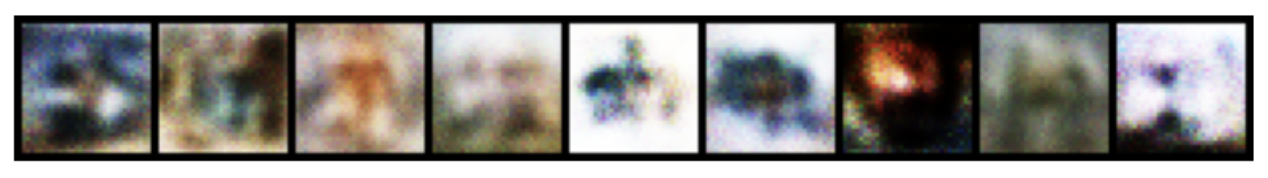

